In [1]:
import csv
import multiprocessing
import os
import random
import shutil
import time
import math

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from solver.simulated_annealing import SimulatedAnnealing, run_simulated_annealing
from solver.max_weighted_cnf import MaxWeightedCNF
from solver.optimum import Optimum

In [3]:
DATA_SUITES = (
    'wuf20-71',
    'wuf20-71R',
    'wuf20-91',
    'wuf20-91R',
    'wuf50-200',
    'wuf50-218',
    'wuf50-218R',
    'wuf75-325',
    'wuf100-430',
)

DATA_SUITES_VARIATIONS = (
    'M',
    'N',
    'Q',
    'R',
)

In [4]:
DATA_DIRECTORY = 'data'
OUTPUT_DIRECTORY = 'output'
BACKUP_DIRECTORY = 'backup'

In [5]:
def flatten(list):
    return [item for sublist in list for item in sublist]

In [6]:
# RUNS = 1
#
# def flatten(list):
#     return [item for sublist in list for item in sublist]
#
# if not os.path.exists(BACKUP_DIRECTORY):
#     os.mkdir(BACKUP_DIRECTORY)
# BACKUP_TIMESTAMP = time.time().__str__()
#
# if os.path.exists(OUTPUT_DIRECTORY):
#     shutil.copytree(OUTPUT_DIRECTORY, os.path.join(BACKUP_DIRECTORY, BACKUP_TIMESTAMP))
#     shutil.rmtree(OUTPUT_DIRECTORY)
# os.mkdir(OUTPUT_DIRECTORY)
#
# for suite in DATA_SUITES:
#     os.mkdir(os.path.join(OUTPUT_DIRECTORY, suite))
#
#     for suite_variation in DATA_SUITES_VARIATIONS:
#         print(suite, suite_variation)
#
#         os.mkdir(os.path.join(OUTPUT_DIRECTORY, suite, suite_variation))
#         sa_output = open(os.path.join(OUTPUT_DIRECTORY, suite, suite_variation, 'sa.csv'), 'w')
#
#         sa_heading = ['instance', 'weight', 'satisfied_clauses', 'clauses',
#                       'true_variables', 'variables', 'current_objective_history', 'best_objective_history']
#         sa_writer = csv.writer(sa_output)
#
#         sa_writer.writerow(sa_heading)
#
#         optimum = None
#         optimum_path = os.path.join(DATA_DIRECTORY, suite, f'{suite}-{suite_variation}-opt.dat')
#
#         if os.path.exists(optimum_path):
#             optimum = Optimum(optimum_path)
#
#         for root, _, files in os.walk(os.path.join(DATA_DIRECTORY, suite, f'{suite}-{suite_variation}')):
#             sas = flatten([
#                 [
#                     SimulatedAnnealing(
#                         MaxWeightedCNF(os.path.join(root, file))
#                     )
#                 ] * RUNS for file in files
#             ])
#
#             pool = multiprocessing.Pool(processes=8)
#
#             sa_results = list(tqdm(pool.imap(run_simulated_annealing, sas), total=len(sas)))
#
#             sa_results = [(result[0].split('/')[-1],
#                            result[1], result[2], result[3], result[4],
#                            result[5], result[6], result[7]) for result in sa_results]
#
#             sa_results.sort(key=lambda result: result[0])
#
#             sa_writer.writerows(sa_results)

In [8]:
def run_simulation(suite, suite_variation, instance, initial_temperature):
    _, weight, satisfied_clauses, clauses, true_variables, variables, current_objective_history, best_objective_history = SimulatedAnnealing(
        MaxWeightedCNF(os.path.join(DATA_DIRECTORY, suite, f'{suite}-{suite_variation}', instance)),
        initial_temperature=initial_temperature
    ).run(record_history=True)

    optimum_path = os.path.join(DATA_DIRECTORY, suite, f'{suite}-{suite_variation}-opt.dat')
    optimum = Optimum(optimum_path)

    optimal_weight = optimum.optimal_weight(instance[1:].rstrip('.mwcnf'))

    return optimal_weight, weight, satisfied_clauses, clauses, true_variables, variables, current_objective_history, best_objective_history

In [8]:
def run_experiment_initial_temperature(suite, suite_variation, instance, initial_temperatures=(5000, 2500, 1000, 500)):
    fig, axes = plt.subplots(math.ceil(len(initial_temperatures) / 2), 2, figsize=(20, 20))

    if len(initial_temperatures) % 2 != 0:
        for l in axes[int(len(initial_temperatures) / 2 - 1), 1].get_xaxis().get_majorticklabels():
            l.set_visible(True)
        fig.delaxes(axes[int(len(initial_temperatures) / 2), 1])

    for i, initial_temperature in enumerate(initial_temperatures):
        optimal_weight, weight, satisfied_clauses, clauses, true_variables, variables, current_objective_history, best_objective_history = run_simulation(
            suite, suite_variation, instance, initial_temperature
        )
        optimal_weight_history = [optimal_weight] * len(current_objective_history)

        ax = axes[int(i / 2), i % 2]

        sns.lineplot(data=current_objective_history, label='Current', ax=ax)
        sns.lineplot(data=best_objective_history, label='Best', ax=ax)
        sns.lineplot(data=optimal_weight_history, label='Optimal', ax=ax)

        ax.set_title(
            f'initial temperature: {initial_temperature}\nsatisfied clauses {satisfied_clauses}/{clauses}\ntrue variables: {true_variables}/{variables}\nweight: {weight}/{optimal_weight} ({round(100 * (weight / optimal_weight))}%)')
        ax.set_xlabel('Steps')
        ax.set_ylabel('Weight')
        ax.legend()

    fig.suptitle(f'Initial temperature experiment\n{suite}-{suite_variation}/{instance}', fontsize=30)
    #fig.tight_layout(pad=5, rect=[0, 0.03, 1, 0.95])

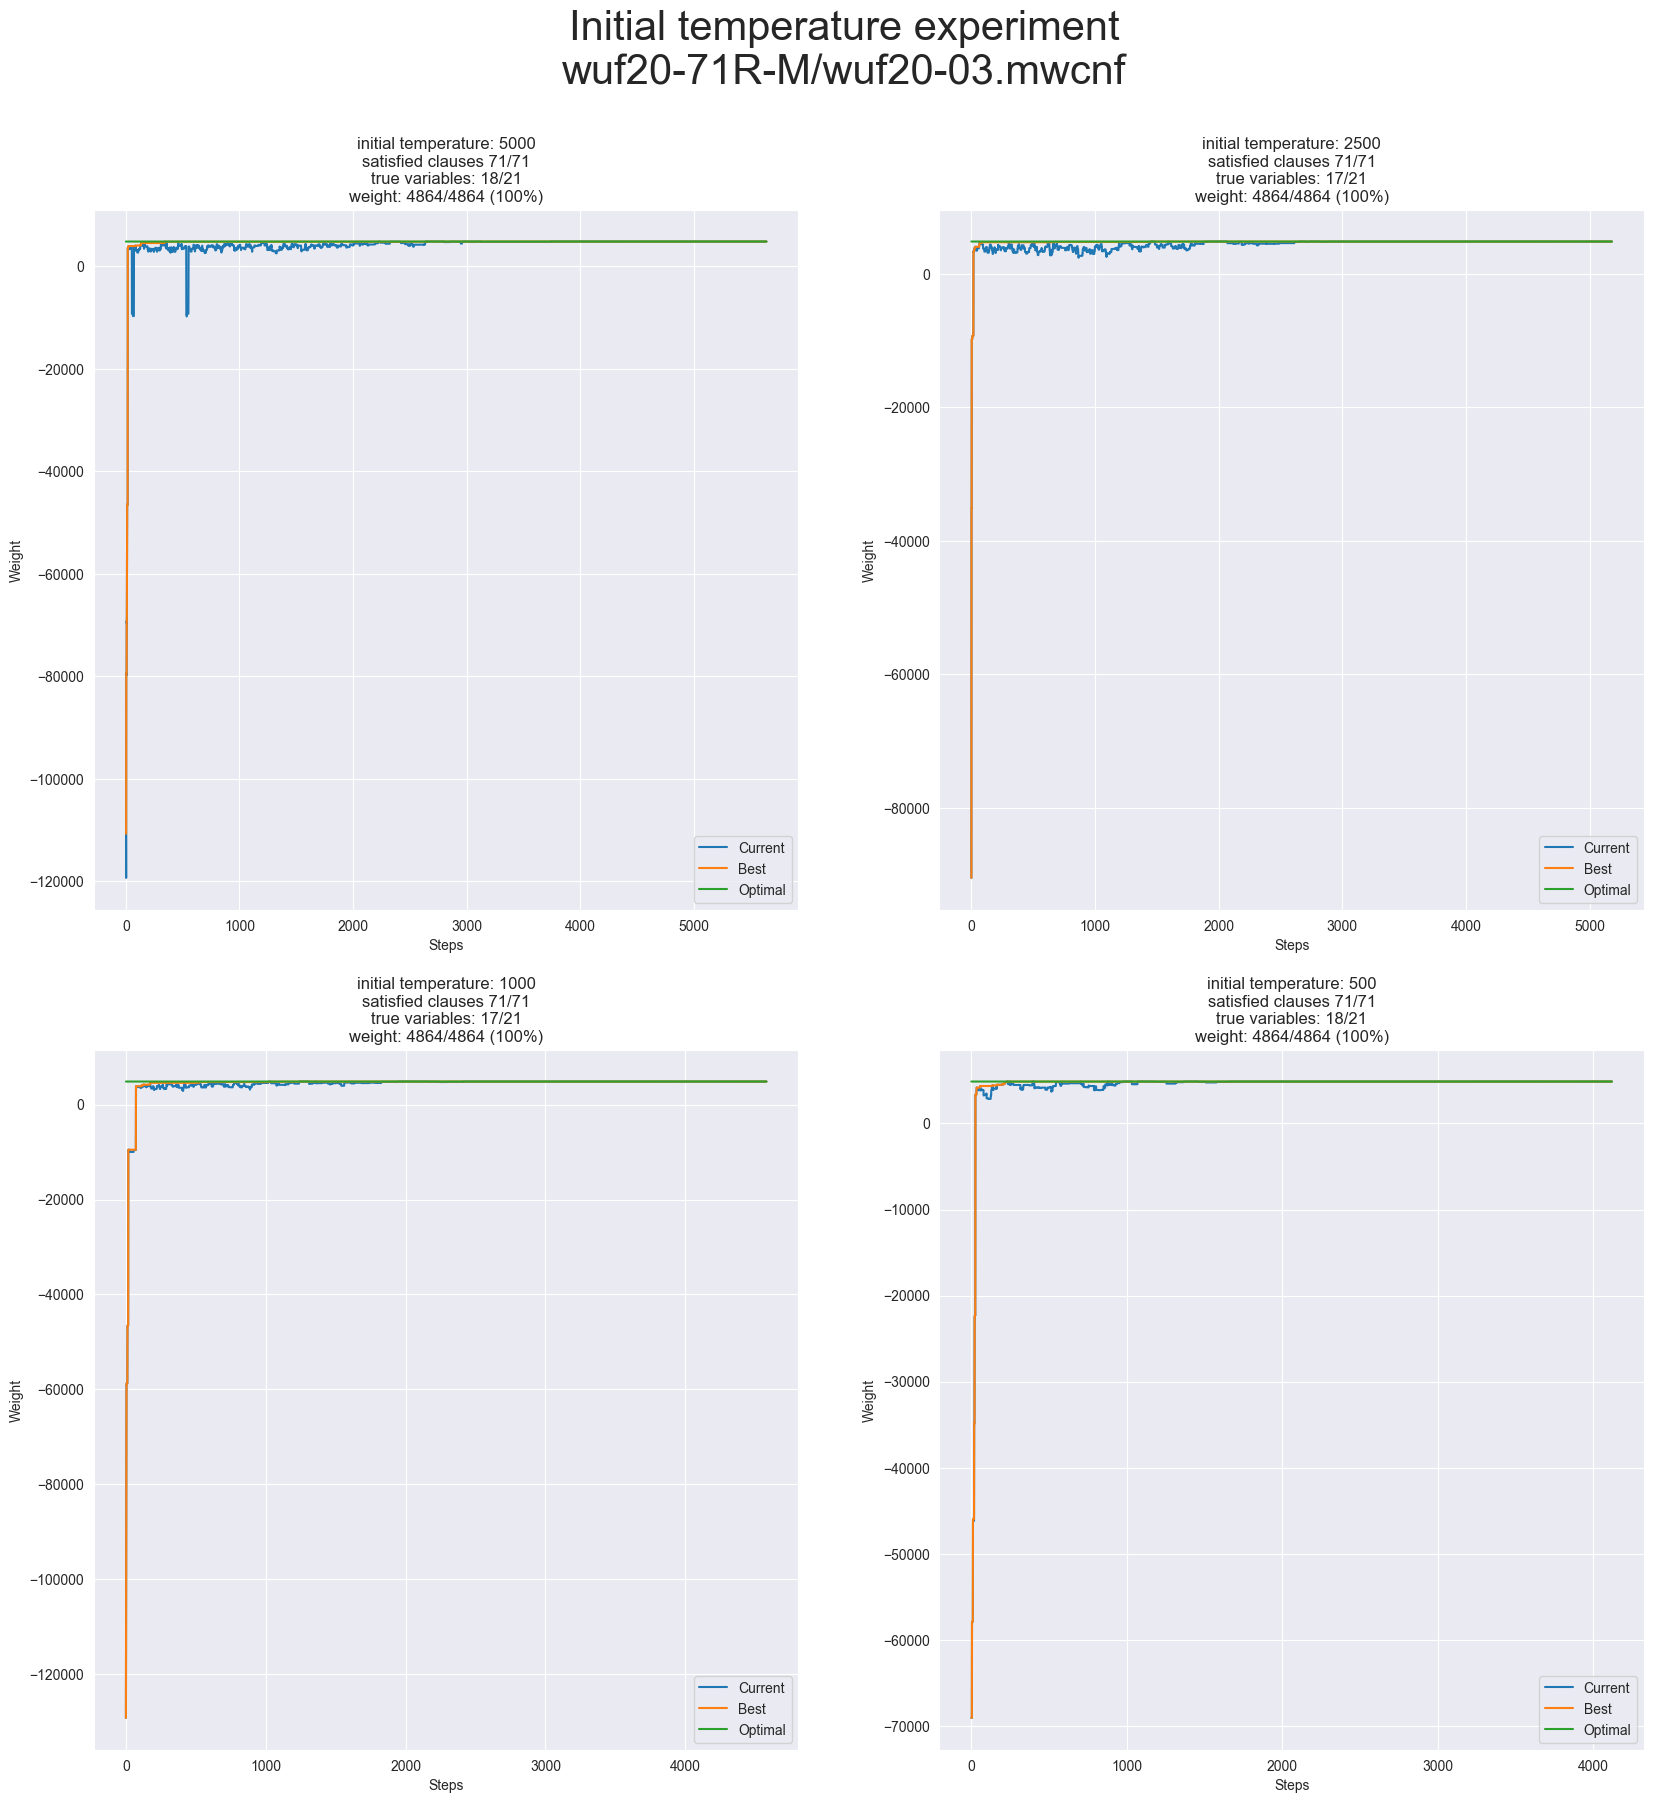

In [9]:
suite = 'wuf20-71R'
suite_variation = 'M'
instance = 'wuf20-03.mwcnf'

run_experiment_initial_temperature(suite, suite_variation, instance)

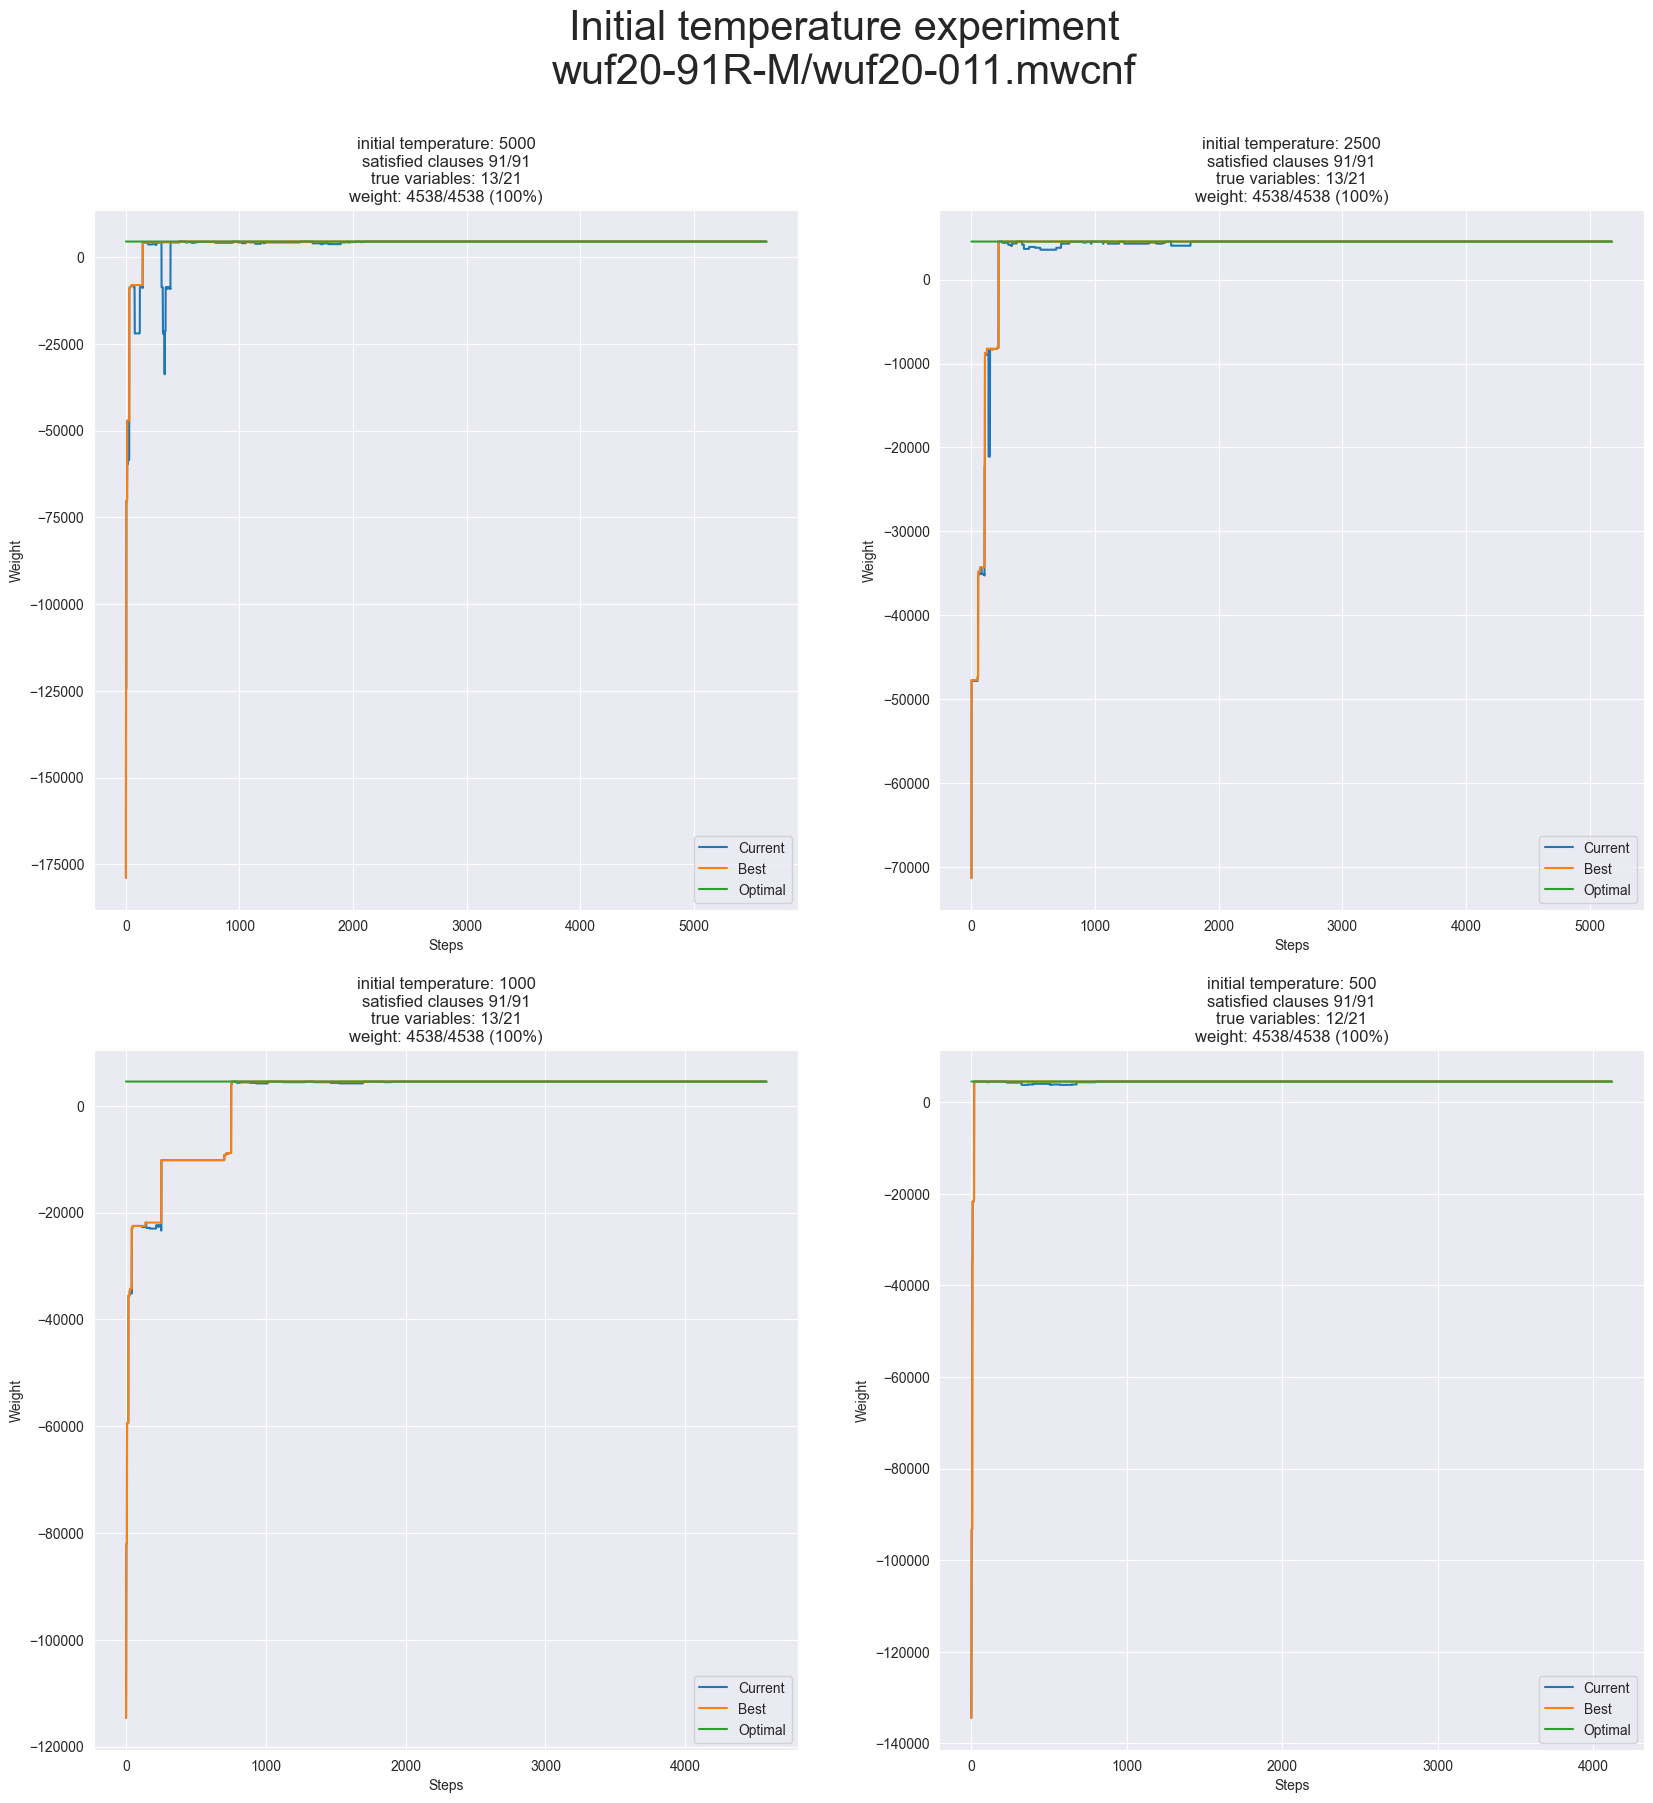

In [10]:
suite = 'wuf20-91R'
suite_variation = 'M'
instance = 'wuf20-011.mwcnf'

run_experiment_initial_temperature(suite, suite_variation, instance)

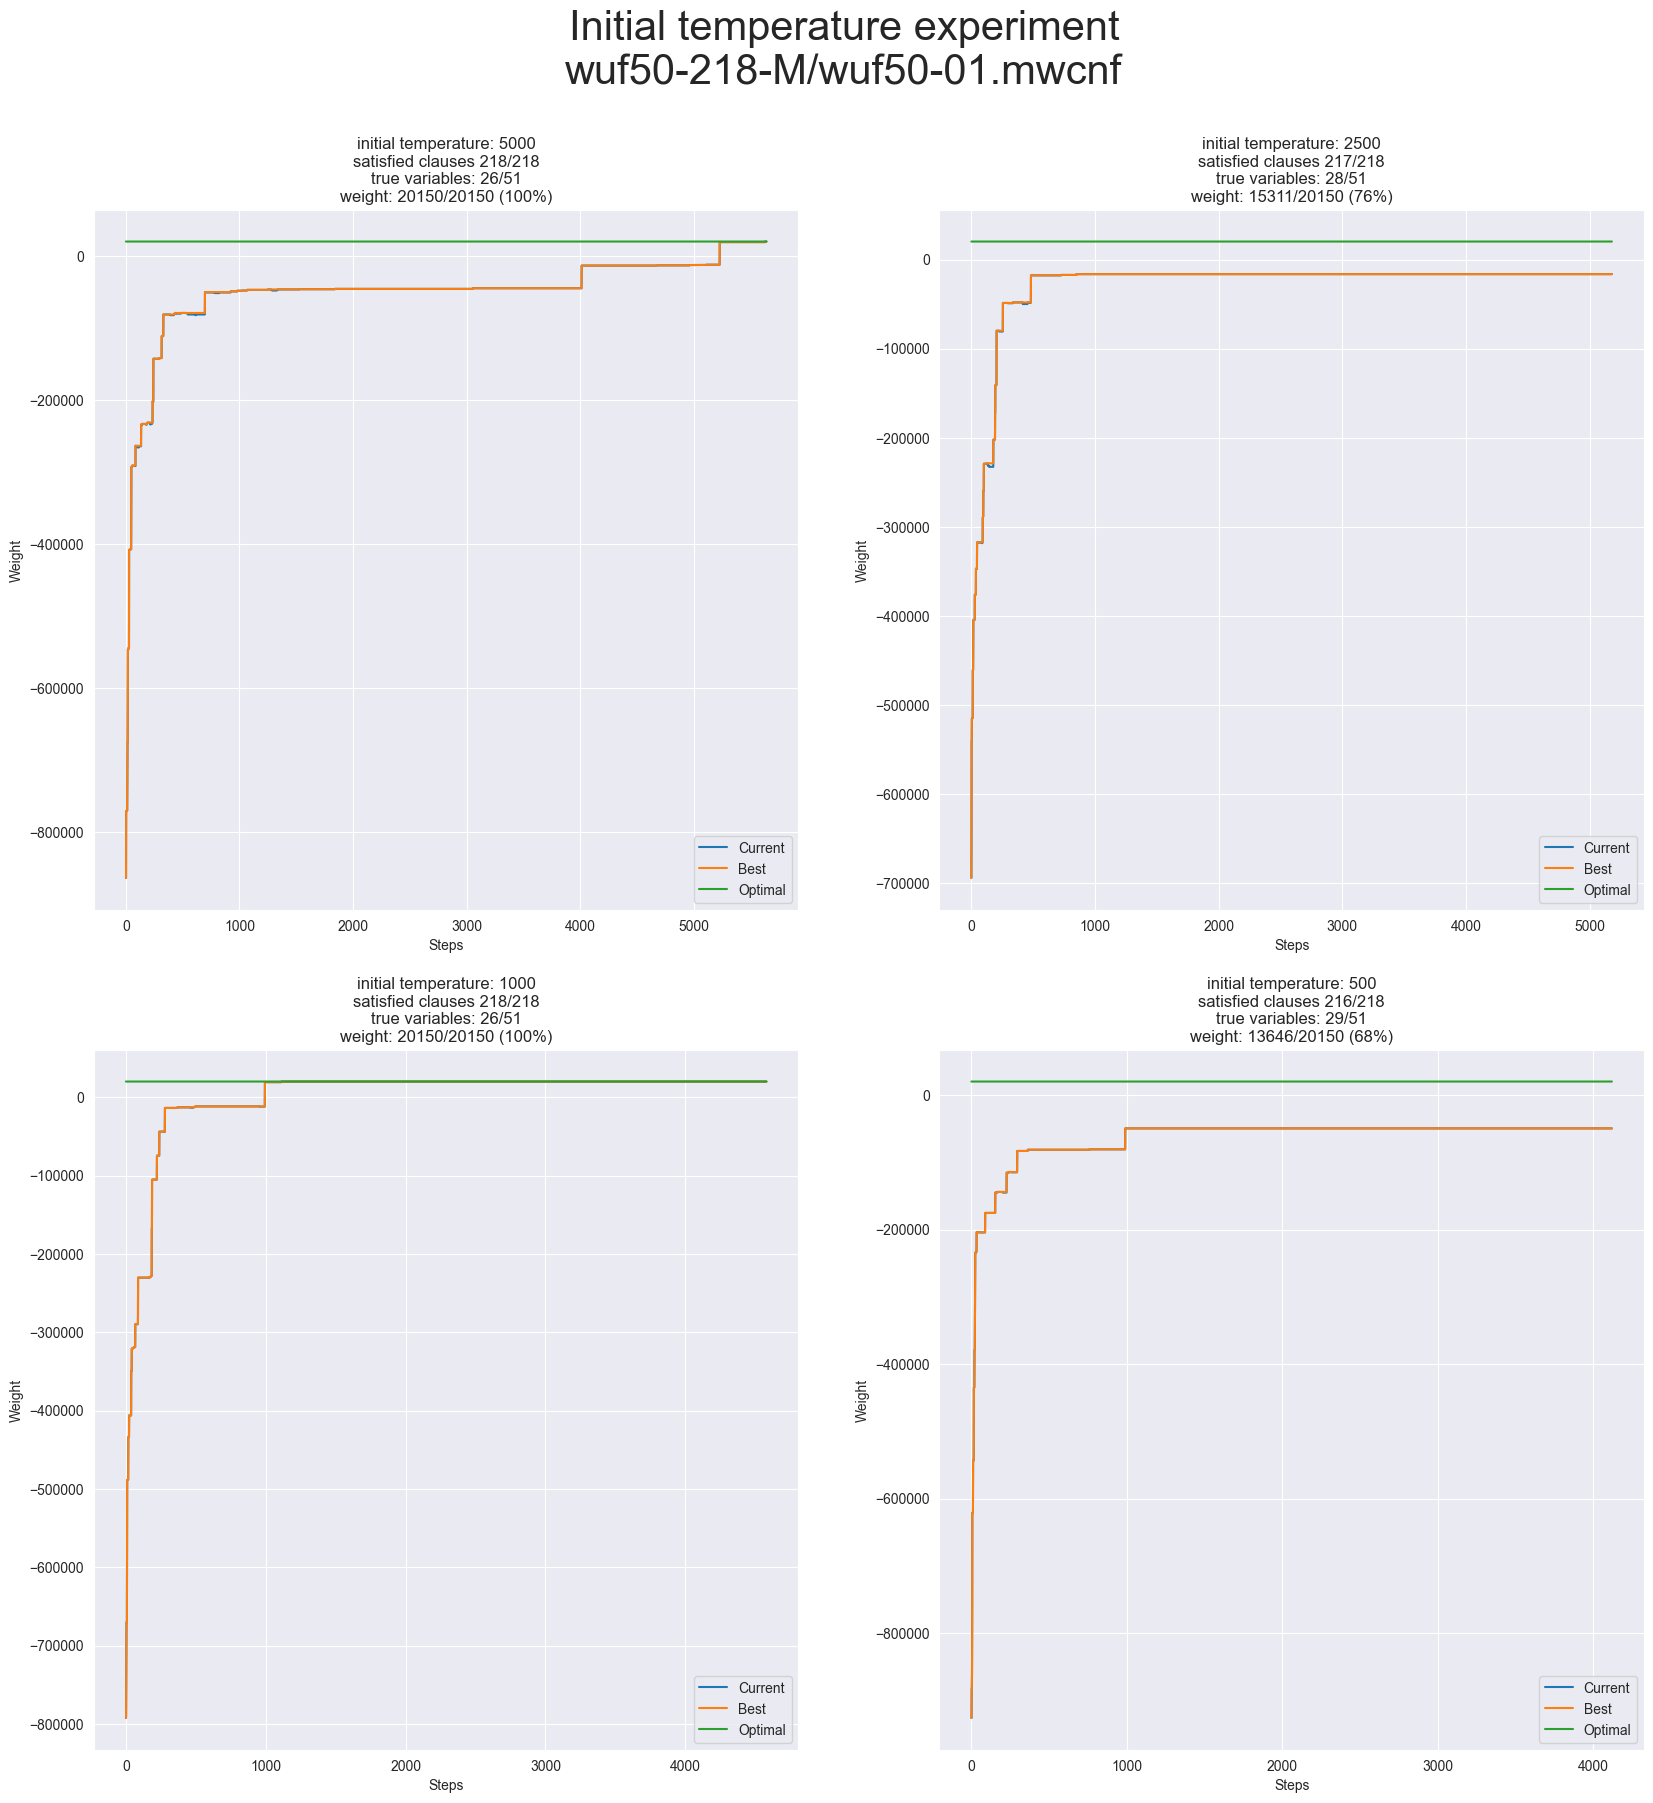

In [11]:
suite = 'wuf50-218'
suite_variation = 'M'
instance = 'wuf50-01.mwcnf'

run_experiment_initial_temperature(suite, suite_variation, instance)

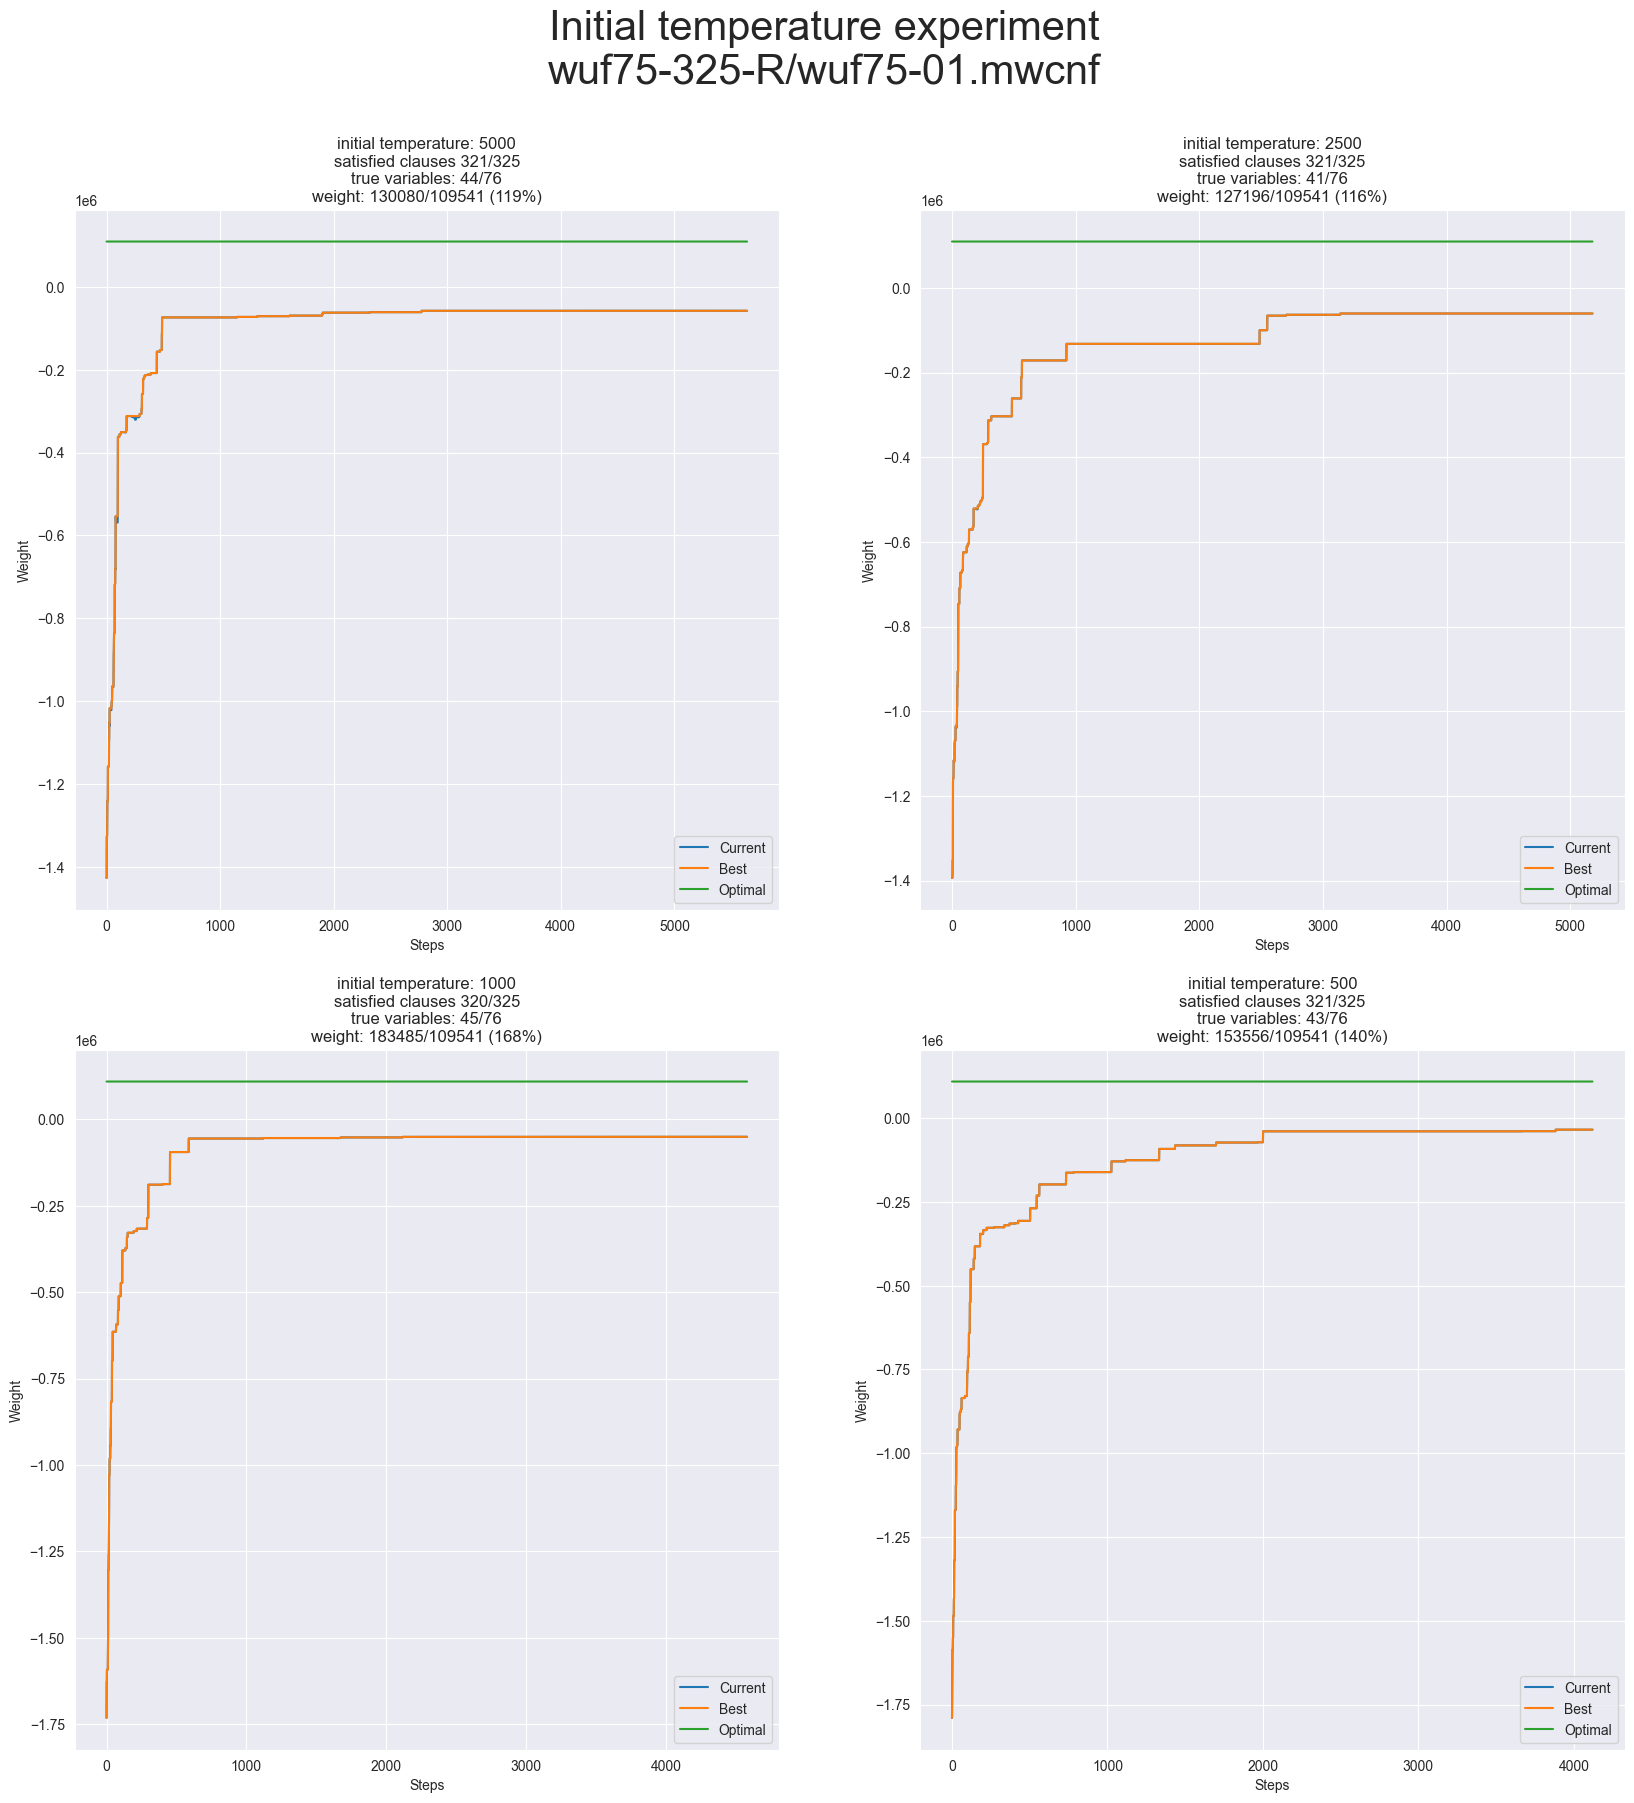

In [12]:
suite = 'wuf75-325'
suite_variation = 'R'
instance = 'wuf75-01.mwcnf'

run_experiment_initial_temperature(suite, suite_variation, instance)

In [13]:
# suite = 'wuf75-325'
# suite_variation = 'R'
# instance = 'wuf75-01.mwcnf'
#
# run_experiment_initial_temperature(suite, suite_variation, instance)

In [9]:
def run_batch(suite, suite_variation, sa_kwargs, runs=1):
    print(suite, suite_variation, sa_kwargs)

    for root, _, files in os.walk(os.path.join(DATA_DIRECTORY, suite, f'{suite}-{suite_variation}')):
        sas = flatten([
            [
                SimulatedAnnealing(
                    MaxWeightedCNF(os.path.join(root, file)),
                    **sa_kwargs
                )
            ] * runs for file in files
        ])

        pool = multiprocessing.Pool(processes=8)

        return list(tqdm(pool.imap(run_simulated_annealing, sas), total=len(sas)))

In [10]:
def run_initial_temperature_experiemnts():
    experiment = {}

    # for suite in ('wuf20-71R', 'wuf20-91R', 'wuf50-218R', 'wuf75-325'):
    for suite in ('wuf20-71R', 'wuf50-218R'):
        experiment_suite = []
        for suite_variation in ('M', 'N', 'Q', 'R'):
            # for suite_variation in DATA_SUITES_VARIATIONS:
            for initial_temperature in [6000, 5000, 4000, 3000, 2000, 1000, 500]:
                sa_results = run_batch(suite, suite_variation, sa_kwargs={
                    'initial_temperature': initial_temperature
                })

                optimum_path = os.path.join(DATA_DIRECTORY, suite, f'{suite}-{suite_variation}-opt.dat')
                optimum = Optimum(optimum_path)

                accurate = 0
                for result in sa_results:
                    instance = result[0].split('/')[-1]
                    weight = result[1]

                    optimal_weight = optimum.optimal_weight(instance[1:].rstrip('.mwcnf'))

                    if weight == optimal_weight:
                        accurate += 1

                accuracy = round(100 * (accurate / len(sa_results)), 1)

                experiment_suite.append({
                    'suite': suite,
                    'variation': suite_variation,
                    'initial_temperature': initial_temperature,
                    'accuracy': accuracy,
                })
        experiment[suite] = experiment_suite
    return experiment

In [16]:
initial_temperature_experiments = run_initial_temperature_experiemnts()

wuf20-71R M 6000


100%|██████████| 100/100 [00:10<00:00,  9.33it/s]

wuf20-71R M 5000



100%|██████████| 100/100 [00:12<00:00,  7.97it/s]

wuf20-71R M 4000



100%|██████████| 100/100 [00:12<00:00,  7.92it/s]

wuf20-71R M 3000



100%|██████████| 100/100 [00:13<00:00,  7.33it/s]

wuf20-71R M 2000



100%|██████████| 100/100 [00:10<00:00,  9.48it/s]

wuf20-71R M 1000



100%|██████████| 100/100 [00:09<00:00, 10.10it/s]


wuf20-71R M 500


100%|██████████| 100/100 [00:09<00:00, 10.80it/s]

wuf20-71R N 6000



100%|██████████| 100/100 [00:12<00:00,  8.30it/s]

wuf20-71R N 5000



100%|██████████| 100/100 [00:12<00:00,  8.09it/s]

wuf20-71R N 4000



100%|██████████| 100/100 [00:09<00:00, 10.20it/s]

wuf20-71R N 3000



100%|██████████| 100/100 [00:09<00:00, 10.69it/s]

wuf20-71R N 2000



100%|██████████| 100/100 [00:10<00:00,  9.52it/s]

wuf20-71R N 1000



100%|██████████| 100/100 [00:12<00:00,  7.93it/s]

wuf20-71R N 500



100%|██████████| 100/100 [00:11<00:00,  8.67it/s]

wuf20-71R Q 6000



100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


wuf20-71R Q 5000


100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


wuf20-71R Q 4000


100%|██████████| 100/100 [00:11<00:00,  8.78it/s]

wuf20-71R Q 3000



100%|██████████| 100/100 [00:09<00:00, 10.55it/s]


wuf20-71R Q 2000


100%|██████████| 100/100 [00:12<00:00,  7.91it/s]

wuf20-71R Q 1000



100%|██████████| 100/100 [00:08<00:00, 11.49it/s]


wuf20-71R Q 500


100%|██████████| 100/100 [00:10<00:00,  9.86it/s]


wuf20-71R R 6000


100%|██████████| 100/100 [00:16<00:00,  6.18it/s]

wuf20-71R R 5000



100%|██████████| 100/100 [00:12<00:00,  7.88it/s]

wuf20-71R R 4000



100%|██████████| 100/100 [00:10<00:00,  9.52it/s]


wuf20-71R R 3000


100%|██████████| 100/100 [00:11<00:00,  8.60it/s]


wuf20-71R R 2000


100%|██████████| 100/100 [00:11<00:00,  9.04it/s]

wuf20-71R R 1000



100%|██████████| 100/100 [00:09<00:00, 10.23it/s]

wuf20-71R R 500



100%|██████████| 100/100 [00:07<00:00, 12.62it/s]


wuf50-218R M 6000


100%|██████████| 100/100 [00:33<00:00,  3.02it/s]

wuf50-218R M 5000



100%|██████████| 100/100 [00:35<00:00,  2.79it/s]


wuf50-218R M 4000


100%|██████████| 100/100 [00:32<00:00,  3.11it/s]

wuf50-218R M 3000



100%|██████████| 100/100 [00:28<00:00,  3.54it/s]

wuf50-218R M 2000



100%|██████████| 100/100 [00:32<00:00,  3.12it/s]

wuf50-218R M 1000



100%|██████████| 100/100 [00:27<00:00,  3.67it/s]


wuf50-218R M 500


100%|██████████| 100/100 [00:24<00:00,  4.00it/s]


wuf50-218R N 6000


100%|██████████| 100/100 [00:30<00:00,  3.23it/s]

wuf50-218R N 5000



100%|██████████| 100/100 [00:27<00:00,  3.58it/s]

wuf50-218R N 4000



100%|██████████| 100/100 [00:18<00:00,  5.27it/s]


wuf50-218R N 3000


100%|██████████| 100/100 [00:09<00:00, 10.23it/s]

wuf50-218R N 2000



100%|██████████| 100/100 [00:09<00:00, 10.35it/s]

wuf50-218R N 1000



100%|██████████| 100/100 [00:08<00:00, 11.35it/s]

wuf50-218R N 500



100%|██████████| 100/100 [00:07<00:00, 12.50it/s]

wuf50-218R Q 6000



100%|██████████| 100/100 [00:11<00:00,  8.90it/s]

wuf50-218R Q 5000



100%|██████████| 100/100 [00:11<00:00,  8.98it/s]


wuf50-218R Q 4000


100%|██████████| 100/100 [00:11<00:00,  9.06it/s]

wuf50-218R Q 3000



100%|██████████| 100/100 [00:10<00:00,  9.21it/s]

wuf50-218R Q 2000



100%|██████████| 100/100 [00:10<00:00,  9.45it/s]

wuf50-218R Q 1000



100%|██████████| 100/100 [00:09<00:00, 10.54it/s]


wuf50-218R Q 500


100%|██████████| 100/100 [00:08<00:00, 11.66it/s]

wuf50-218R R 6000



100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


wuf50-218R R 5000


100%|██████████| 100/100 [00:12<00:00,  8.33it/s]


wuf50-218R R 4000


100%|██████████| 100/100 [00:11<00:00,  8.75it/s]

wuf50-218R R 3000



100%|██████████| 100/100 [00:11<00:00,  8.90it/s]

wuf50-218R R 2000



100%|██████████| 100/100 [00:10<00:00,  9.48it/s]

wuf50-218R R 1000



100%|██████████| 100/100 [00:09<00:00, 10.47it/s]

wuf50-218R R 500



100%|██████████| 100/100 [00:08<00:00, 11.32it/s]


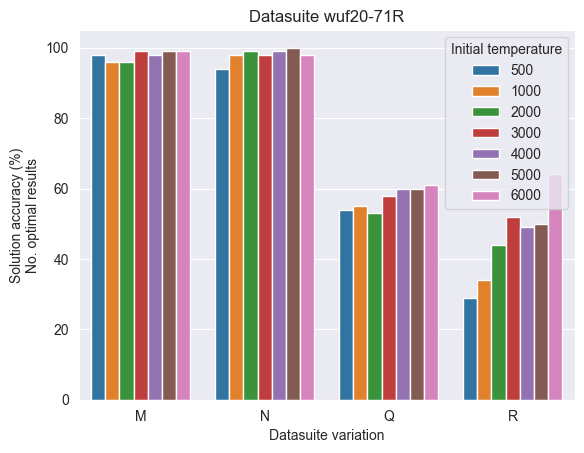

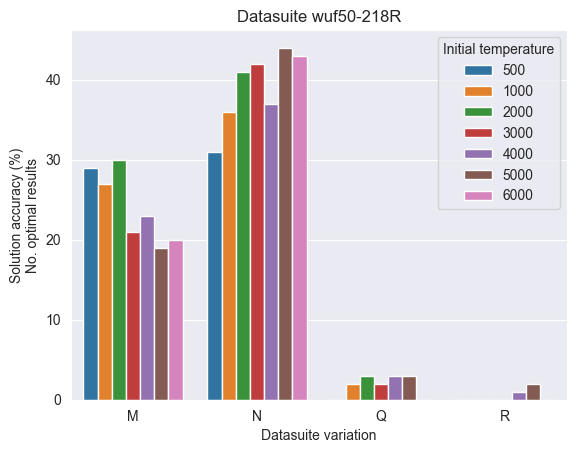

In [20]:
for experiment in initial_temperature_experiments:
    df = pd.DataFrame.from_records(initial_temperature_experiments[experiment])
    df['Initial temperature'] = df['initial_temperature']
    ax = sns.barplot(data=df,
                     x='variation', y='accuracy',
                     hue='Initial temperature',
                     errorbar=None)
    ax.set_title(f'Datasuite {experiment}')
    ax.set_xlabel('Datasuite variation')
    ax.set_ylabel(f'Solution accuracy (%)\nNo. optimal results')
    plt.show()

In [11]:
def run_penalty_experiemnts():
    experiment = {}

    # for suite in ('wuf20-71R', 'wuf20-91R', 'wuf50-218R', 'wuf75-325'):
    for suite in ('wuf20-71R', 'wuf50-218R'):
        experiment_suite = []
        for suite_variation in ('M', 'N', 'Q', 'R'):
            # for suite_variation in DATA_SUITES_VARIATIONS:
            for penalty in [-7000, -5000, -3000, -1500, -1000, -500, 0]:
                sa_results = run_batch(suite, suite_variation, sa_kwargs={
                    'penalty': penalty
                })

                optimum_path = os.path.join(DATA_DIRECTORY, suite, f'{suite}-{suite_variation}-opt.dat')
                optimum = Optimum(optimum_path)

                accurate = 0
                for result in sa_results:
                    instance = result[0].split('/')[-1]
                    weight = result[1]

                    optimal_weight = optimum.optimal_weight(instance[1:].rstrip('.mwcnf'))

                    if weight == optimal_weight:
                        accurate += 1

                accuracy = round(100 * (accurate / len(sa_results)), 1)

                experiment_suite.append({
                    'suite': suite,
                    'variation': suite_variation,
                    'penalty': penalty,
                    'accuracy': accuracy,
                })
        experiment[suite] = experiment_suite
    return experiment

In [12]:
penalty_experiments = run_penalty_experiemnts()

wuf20-71R M {'penalty': -7000}


100%|██████████| 100/100 [00:04<00:00, 24.20it/s]

wuf20-71R M {'penalty': -5000}



100%|██████████| 100/100 [00:04<00:00, 24.50it/s]

wuf20-71R M {'penalty': -3000}



100%|██████████| 100/100 [00:03<00:00, 25.92it/s]

wuf20-71R M {'penalty': -1500}



100%|██████████| 100/100 [00:04<00:00, 23.82it/s]

wuf20-71R M {'penalty': -1000}



100%|██████████| 100/100 [00:04<00:00, 24.14it/s]

wuf20-71R M {'penalty': -500}



100%|██████████| 100/100 [00:04<00:00, 24.88it/s]

wuf20-71R M {'penalty': 0}



100%|██████████| 100/100 [00:04<00:00, 24.71it/s]


wuf20-71R N {'penalty': -7000}


100%|██████████| 100/100 [00:04<00:00, 24.47it/s]

wuf20-71R N {'penalty': -5000}



100%|██████████| 100/100 [00:04<00:00, 23.83it/s]


wuf20-71R N {'penalty': -3000}


100%|██████████| 100/100 [00:04<00:00, 23.98it/s]

wuf20-71R N {'penalty': -1500}



100%|██████████| 100/100 [00:04<00:00, 23.74it/s]

wuf20-71R N {'penalty': -1000}



100%|██████████| 100/100 [00:04<00:00, 24.09it/s]

wuf20-71R N {'penalty': -500}



100%|██████████| 100/100 [00:04<00:00, 24.03it/s]

wuf20-71R N {'penalty': 0}



100%|██████████| 100/100 [00:04<00:00, 23.96it/s]

wuf20-71R Q {'penalty': -7000}



100%|██████████| 100/100 [00:04<00:00, 24.07it/s]

wuf20-71R Q {'penalty': -5000}



100%|██████████| 100/100 [00:04<00:00, 23.98it/s]

wuf20-71R Q {'penalty': -3000}



100%|██████████| 100/100 [00:04<00:00, 23.97it/s]

wuf20-71R Q {'penalty': -1500}



100%|██████████| 100/100 [00:04<00:00, 23.43it/s]

wuf20-71R Q {'penalty': -1000}



100%|██████████| 100/100 [00:04<00:00, 23.28it/s]

wuf20-71R Q {'penalty': -500}



100%|██████████| 100/100 [00:04<00:00, 22.89it/s]

wuf20-71R Q {'penalty': 0}



100%|██████████| 100/100 [00:04<00:00, 22.65it/s]

wuf20-71R R {'penalty': -7000}



100%|██████████| 100/100 [00:04<00:00, 23.13it/s]

wuf20-71R R {'penalty': -5000}



100%|██████████| 100/100 [00:04<00:00, 23.19it/s]

wuf20-71R R {'penalty': -3000}



100%|██████████| 100/100 [00:04<00:00, 23.30it/s]

wuf20-71R R {'penalty': -1500}



100%|██████████| 100/100 [00:04<00:00, 23.27it/s]


wuf20-71R R {'penalty': -1000}


100%|██████████| 100/100 [00:04<00:00, 23.35it/s]

wuf20-71R R {'penalty': -500}



100%|██████████| 100/100 [00:04<00:00, 23.18it/s]


wuf20-71R R {'penalty': 0}


100%|██████████| 100/100 [00:04<00:00, 23.17it/s]

wuf50-218R M {'penalty': -7000}



100%|██████████| 100/100 [00:12<00:00,  8.12it/s]


wuf50-218R M {'penalty': -5000}


100%|██████████| 100/100 [00:12<00:00,  8.05it/s]


wuf50-218R M {'penalty': -3000}


100%|██████████| 100/100 [00:13<00:00,  7.41it/s]

wuf50-218R M {'penalty': -1500}



100%|██████████| 100/100 [00:13<00:00,  7.48it/s]

wuf50-218R M {'penalty': -1000}



100%|██████████| 100/100 [00:25<00:00,  3.97it/s]


wuf50-218R M {'penalty': -500}


100%|██████████| 100/100 [00:28<00:00,  3.50it/s]

wuf50-218R M {'penalty': 0}



100%|██████████| 100/100 [00:28<00:00,  3.52it/s]

wuf50-218R N {'penalty': -7000}



100%|██████████| 100/100 [00:28<00:00,  3.55it/s]

wuf50-218R N {'penalty': -5000}



100%|██████████| 100/100 [00:27<00:00,  3.60it/s]


wuf50-218R N {'penalty': -3000}


100%|██████████| 100/100 [00:11<00:00,  8.62it/s]


wuf50-218R N {'penalty': -1500}


100%|██████████| 100/100 [00:11<00:00,  8.86it/s]

wuf50-218R N {'penalty': -1000}



100%|██████████| 100/100 [00:11<00:00,  8.68it/s]

wuf50-218R N {'penalty': -500}



100%|██████████| 100/100 [00:12<00:00,  7.97it/s]


wuf50-218R N {'penalty': 0}


100%|██████████| 100/100 [00:12<00:00,  7.98it/s]

wuf50-218R Q {'penalty': -7000}



100%|██████████| 100/100 [00:13<00:00,  7.28it/s]

wuf50-218R Q {'penalty': -5000}



100%|██████████| 100/100 [00:13<00:00,  7.43it/s]


wuf50-218R Q {'penalty': -3000}


100%|██████████| 100/100 [00:12<00:00,  7.99it/s]

wuf50-218R Q {'penalty': -1500}



100%|██████████| 100/100 [00:13<00:00,  7.48it/s]

wuf50-218R Q {'penalty': -1000}



100%|██████████| 100/100 [00:12<00:00,  7.82it/s]

wuf50-218R Q {'penalty': -500}



100%|██████████| 100/100 [00:12<00:00,  7.95it/s]

wuf50-218R Q {'penalty': 0}



100%|██████████| 100/100 [00:12<00:00,  7.88it/s]

wuf50-218R R {'penalty': -7000}



100%|██████████| 100/100 [00:12<00:00,  8.06it/s]


wuf50-218R R {'penalty': -5000}


100%|██████████| 100/100 [00:12<00:00,  8.07it/s]

wuf50-218R R {'penalty': -3000}



100%|██████████| 100/100 [00:12<00:00,  7.86it/s]


wuf50-218R R {'penalty': -1500}


100%|██████████| 100/100 [00:12<00:00,  7.92it/s]

wuf50-218R R {'penalty': -1000}



100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


wuf50-218R R {'penalty': -500}


100%|██████████| 100/100 [00:15<00:00,  6.60it/s]

wuf50-218R R {'penalty': 0}



100%|██████████| 100/100 [00:12<00:00,  7.73it/s]


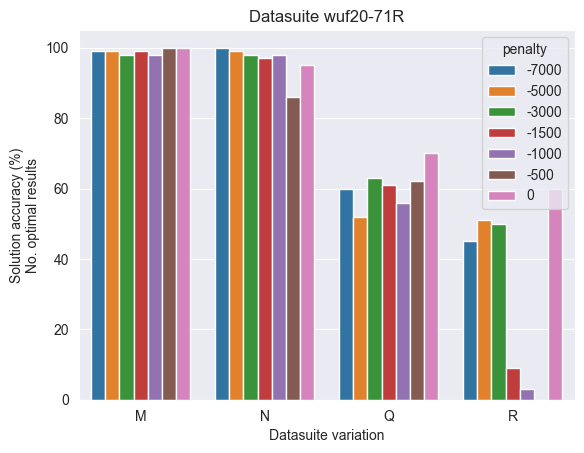

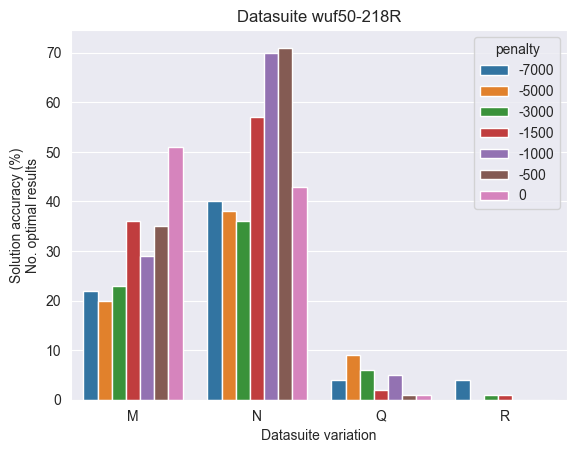

In [13]:
for experiment in penalty_experiments:
    df = pd.DataFrame.from_records(penalty_experiments[experiment])
    ax = sns.barplot(data=df,
                     x='variation', y='accuracy',
                     hue='penalty',
                     errorbar=None)
    ax.set_title(f'Datasuite {experiment}')
    ax.set_xlabel('Datasuite variation')
    ax.set_ylabel(f'Solution accuracy (%)\nNo. optimal results')
    plt.show()

In [14]:
def run_cooling_factor_experiemnts():
    experiment = {}

    # for suite in ('wuf20-71R', 'wuf20-91R', 'wuf50-218R', 'wuf75-325'):
    for suite in ('wuf20-71R', 'wuf50-218R'):
        experiment_suite = []
        for suite_variation in ('M', 'N', 'Q', 'R'):
            # for suite_variation in DATA_SUITES_VARIATIONS:
            for cooling_factor in [0.99, 0.975, 0.95, 0.9, 0.85, 0.8, 0.75]:
                sa_results = run_batch(suite, suite_variation, sa_kwargs={
                    'cooling_factor': cooling_factor
                })

                optimum_path = os.path.join(DATA_DIRECTORY, suite, f'{suite}-{suite_variation}-opt.dat')
                optimum = Optimum(optimum_path)

                accurate = 0
                for result in sa_results:
                    instance = result[0].split('/')[-1]
                    weight = result[1]

                    optimal_weight = optimum.optimal_weight(instance[1:].rstrip('.mwcnf'))

                    if weight == optimal_weight:
                        accurate += 1

                accuracy = round(100 * (accurate / len(sa_results)), 1)

                experiment_suite.append({
                    'suite': suite,
                    'variation': suite_variation,
                    'cooling_factor': cooling_factor,
                    'accuracy': accuracy,
                })
        experiment[suite] = experiment_suite
    return experiment

In [15]:
cooling_factor_experiments = run_cooling_factor_experiemnts()

wuf20-71R M {'cooling_factor': 0.99}


100%|██████████| 100/100 [00:05<00:00, 16.67it/s]

wuf20-71R M {'cooling_factor': 0.975}



100%|██████████| 100/100 [00:02<00:00, 44.60it/s]

wuf20-71R M {'cooling_factor': 0.95}



100%|██████████| 100/100 [00:01<00:00, 73.82it/s]

wuf20-71R M {'cooling_factor': 0.9}



100%|██████████| 100/100 [00:00<00:00, 188.66it/s]

wuf20-71R M {'cooling_factor': 0.85}



100%|██████████| 100/100 [00:00<00:00, 274.96it/s]

wuf20-71R M {'cooling_factor': 0.8}



100%|██████████| 100/100 [00:00<00:00, 368.32it/s]


wuf20-71R M {'cooling_factor': 0.75}


100%|██████████| 100/100 [00:00<00:00, 473.52it/s]

wuf20-71R N {'cooling_factor': 0.99}



100%|██████████| 100/100 [00:06<00:00, 14.49it/s]


wuf20-71R N {'cooling_factor': 0.975}


100%|██████████| 100/100 [00:02<00:00, 41.65it/s]


wuf20-71R N {'cooling_factor': 0.95}


100%|██████████| 100/100 [00:01<00:00, 82.38it/s]

wuf20-71R N {'cooling_factor': 0.9}



100%|██████████| 100/100 [00:00<00:00, 161.75it/s]


wuf20-71R N {'cooling_factor': 0.85}


100%|██████████| 100/100 [00:00<00:00, 272.51it/s]

wuf20-71R N {'cooling_factor': 0.8}



100%|██████████| 100/100 [00:00<00:00, 342.78it/s]


wuf20-71R N {'cooling_factor': 0.75}


100%|██████████| 100/100 [00:00<00:00, 451.21it/s]

wuf20-71R Q {'cooling_factor': 0.99}



100%|██████████| 100/100 [00:07<00:00, 13.33it/s]

wuf20-71R Q {'cooling_factor': 0.975}



100%|██████████| 100/100 [00:02<00:00, 40.18it/s]


wuf20-71R Q {'cooling_factor': 0.95}


100%|██████████| 100/100 [00:01<00:00, 82.04it/s]

wuf20-71R Q {'cooling_factor': 0.9}



100%|██████████| 100/100 [00:00<00:00, 166.51it/s]

wuf20-71R Q {'cooling_factor': 0.85}



100%|██████████| 100/100 [00:00<00:00, 247.99it/s]


wuf20-71R Q {'cooling_factor': 0.8}


100%|██████████| 100/100 [00:00<00:00, 336.25it/s]


wuf20-71R Q {'cooling_factor': 0.75}


100%|██████████| 100/100 [00:00<00:00, 429.22it/s]

wuf20-71R R {'cooling_factor': 0.99}



100%|██████████| 100/100 [00:06<00:00, 15.81it/s]

wuf20-71R R {'cooling_factor': 0.975}



100%|██████████| 100/100 [00:02<00:00, 40.15it/s]


wuf20-71R R {'cooling_factor': 0.95}


100%|██████████| 100/100 [00:01<00:00, 83.99it/s]

wuf20-71R R {'cooling_factor': 0.9}



100%|██████████| 100/100 [00:00<00:00, 124.50it/s]

wuf20-71R R {'cooling_factor': 0.85}



100%|██████████| 100/100 [00:00<00:00, 240.10it/s]

wuf20-71R R {'cooling_factor': 0.8}



100%|██████████| 100/100 [00:00<00:00, 336.85it/s]


wuf20-71R R {'cooling_factor': 0.75}


100%|██████████| 100/100 [00:00<00:00, 426.50it/s]


wuf50-218R M {'cooling_factor': 0.99}


100%|██████████| 100/100 [00:18<00:00,  5.44it/s]

wuf50-218R M {'cooling_factor': 0.975}



100%|██████████| 100/100 [00:07<00:00, 14.24it/s]

wuf50-218R M {'cooling_factor': 0.95}



100%|██████████| 100/100 [00:03<00:00, 28.27it/s]

wuf50-218R M {'cooling_factor': 0.9}



100%|██████████| 100/100 [00:01<00:00, 58.85it/s]

wuf50-218R M {'cooling_factor': 0.85}



100%|██████████| 100/100 [00:01<00:00, 89.38it/s]

wuf50-218R M {'cooling_factor': 0.8}



100%|██████████| 100/100 [00:00<00:00, 115.36it/s]

wuf50-218R M {'cooling_factor': 0.75}



100%|██████████| 100/100 [00:00<00:00, 158.72it/s]


wuf50-218R N {'cooling_factor': 0.99}


100%|██████████| 100/100 [00:19<00:00,  5.11it/s]

wuf50-218R N {'cooling_factor': 0.975}



100%|██████████| 100/100 [00:08<00:00, 12.50it/s]


wuf50-218R N {'cooling_factor': 0.95}


100%|██████████| 100/100 [00:03<00:00, 27.44it/s]

wuf50-218R N {'cooling_factor': 0.9}



100%|██████████| 100/100 [00:01<00:00, 53.07it/s]

wuf50-218R N {'cooling_factor': 0.85}



100%|██████████| 100/100 [00:01<00:00, 84.54it/s]


wuf50-218R N {'cooling_factor': 0.8}


100%|██████████| 100/100 [00:01<00:00, 73.13it/s]

wuf50-218R N {'cooling_factor': 0.75}



100%|██████████| 100/100 [00:00<00:00, 155.72it/s]


wuf50-218R Q {'cooling_factor': 0.99}


100%|██████████| 100/100 [00:18<00:00,  5.40it/s]

wuf50-218R Q {'cooling_factor': 0.975}



100%|██████████| 100/100 [00:07<00:00, 12.53it/s]


wuf50-218R Q {'cooling_factor': 0.95}


100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


wuf50-218R Q {'cooling_factor': 0.9}


100%|██████████| 100/100 [00:01<00:00, 57.35it/s]


wuf50-218R Q {'cooling_factor': 0.85}


100%|██████████| 100/100 [00:01<00:00, 85.81it/s]


wuf50-218R Q {'cooling_factor': 0.8}


100%|██████████| 100/100 [00:00<00:00, 117.91it/s]


wuf50-218R Q {'cooling_factor': 0.75}


100%|██████████| 100/100 [00:00<00:00, 147.14it/s]

wuf50-218R R {'cooling_factor': 0.99}



100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


wuf50-218R R {'cooling_factor': 0.975}


100%|██████████| 100/100 [00:07<00:00, 13.54it/s]

wuf50-218R R {'cooling_factor': 0.95}



100%|██████████| 100/100 [00:03<00:00, 28.00it/s]

wuf50-218R R {'cooling_factor': 0.9}



100%|██████████| 100/100 [00:01<00:00, 55.87it/s]

wuf50-218R R {'cooling_factor': 0.85}



100%|██████████| 100/100 [00:01<00:00, 85.89it/s]

wuf50-218R R {'cooling_factor': 0.8}



100%|██████████| 100/100 [00:00<00:00, 115.99it/s]

wuf50-218R R {'cooling_factor': 0.75}



100%|██████████| 100/100 [00:00<00:00, 148.83it/s]


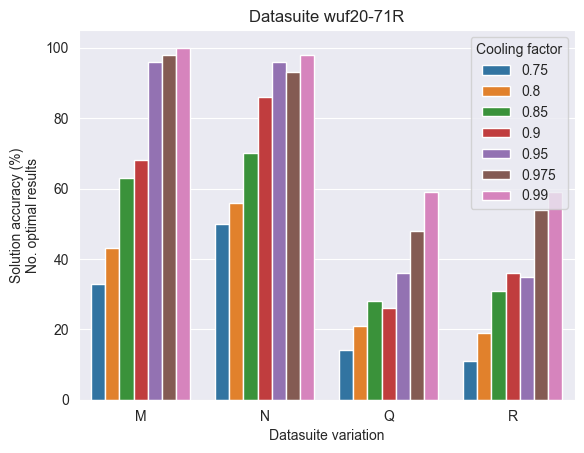

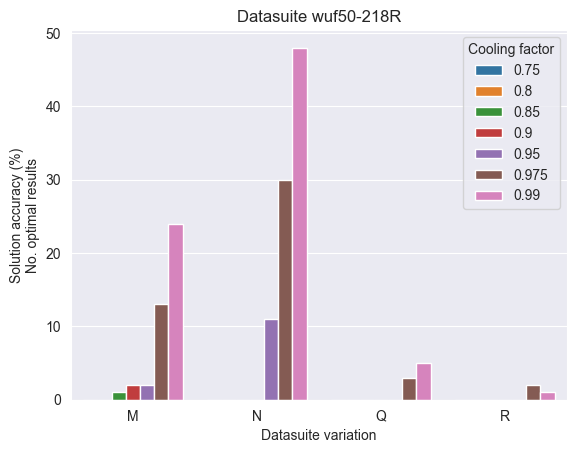

In [17]:
for experiment in cooling_factor_experiments:
    df = pd.DataFrame.from_records(cooling_factor_experiments[experiment])
    df['Cooling factor'] = df['cooling_factor']
    ax = sns.barplot(data=df,
                     x='variation', y='accuracy',
                     hue='Cooling factor',
                     errorbar=None)
    ax.set_title(f'Datasuite {experiment}')
    ax.set_xlabel('Datasuite variation')
    ax.set_ylabel(f'Solution accuracy (%)\nNo. optimal results')
    plt.show()

In [10]:
def run_black_box_experiemnts():
    experiment = {}

    for suite in ('wuf20-71R', 'wuf50-218R'):
        experiment_suite = []
        for suite_variation in ('M', 'N', 'Q', 'R'):
            # for suite_variation in DATA_SUITES_VARIATIONS:
            sa_results = run_batch(suite, suite_variation, sa_kwargs={}, runs=10)

            optimum_path = os.path.join(DATA_DIRECTORY, suite, f'{suite}-{suite_variation}-opt.dat')
            optimum = Optimum(optimum_path)

            accurate = 0
            weight_difference = []
            satisfied_ratio = []
            true_variables_ratio = []

            for result in sa_results:
                instance = result[0].split('/')[-1]
                weight = result[1]

                satisfied_clauses = result[2]
                clauses_count = result[3]

                true_variables = result[4]
                variables_count = result[5]

                optimal_weight = optimum.optimal_weight(instance[1:].rstrip('.mwcnf'))

                if weight == optimal_weight:
                    accurate += 1

                weight_difference.append(weight / optimal_weight)
                satisfied_ratio.append(satisfied_clauses / clauses_count)
                true_variables_ratio.append(true_variables / variables_count)

            accuracy = round(100 * (accurate / len(sa_results)), 1)

            experiment_suite.append({
                'suite': suite,
                'variation': suite_variation,
                'accuracy': accuracy,
                'weight_difference': weight_difference,
                'satisfied_ratio': satisfied_ratio
            })
        experiment[suite] = experiment_suite
    return experiment

In [11]:
black_box_experiemnts = run_black_box_experiemnts()

wuf20-71R M {}


100%|██████████| 1000/1000 [01:04<00:00, 15.44it/s]


wuf20-71R N {}


100%|██████████| 1000/1000 [00:57<00:00, 17.43it/s]


wuf20-71R Q {}


100%|██████████| 1000/1000 [00:57<00:00, 17.41it/s]

wuf20-71R R {}



100%|██████████| 1000/1000 [00:59<00:00, 16.85it/s]

wuf50-218R M {}



100%|██████████| 1000/1000 [02:54<00:00,  5.73it/s]

wuf50-218R N {}



100%|██████████| 1000/1000 [03:09<00:00,  5.29it/s]

wuf50-218R Q {}



100%|██████████| 1000/1000 [02:53<00:00,  5.78it/s]


wuf50-218R R {}


100%|██████████| 1000/1000 [03:24<00:00,  4.89it/s]


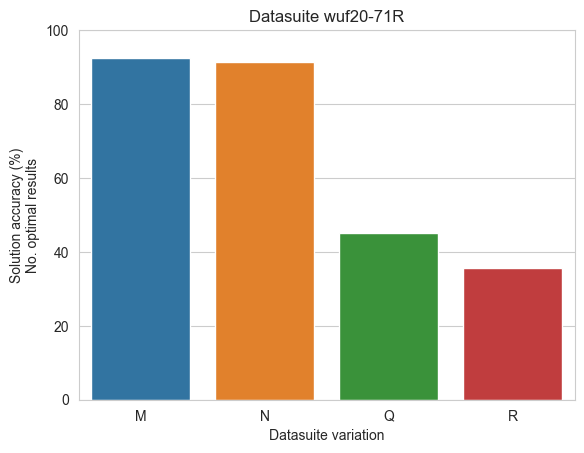

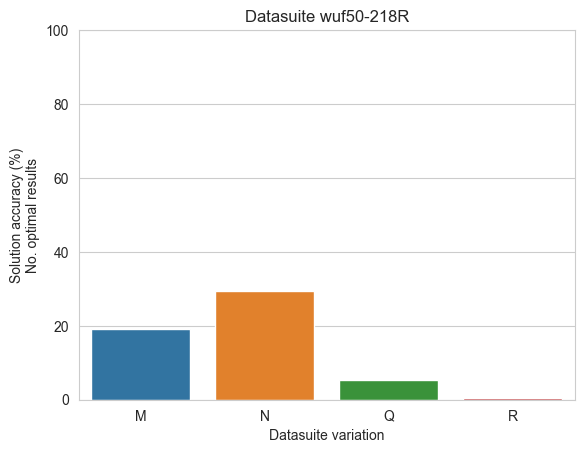

In [13]:
for experiment in black_box_experiemnts:
    df = pd.DataFrame.from_records(black_box_experiemnts[experiment])
    df['Weight difference'] = df['weight_difference']
    df['Satisfied ratio'] = df['satisfied_ratio']
    ax = sns.barplot(data=df,
                     x='variation', y='accuracy',
                     errorbar=None)
    ax.set(ylim=(0, 100))
    ax.set_title(f'Datasuite {experiment}')
    ax.set_xlabel('Datasuite variation')
    ax.set_ylabel(f'Solution accuracy (%)\nNo. optimal results')
    plt.show()

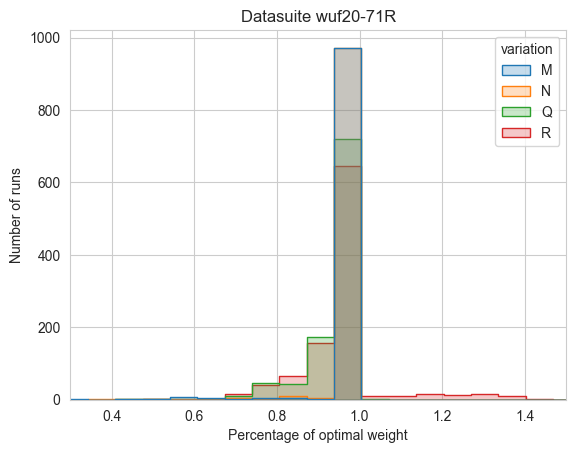

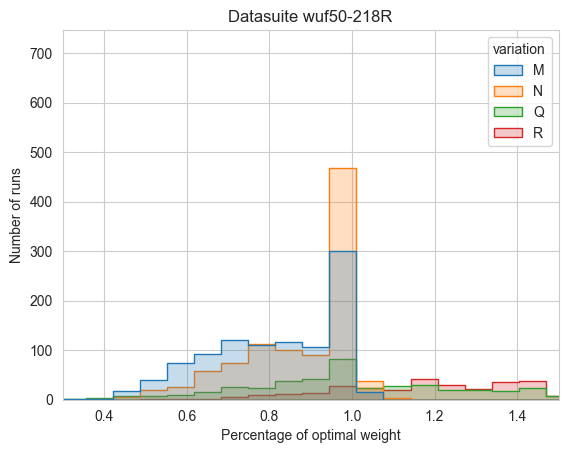

In [107]:
for experiment in black_box_experiemnts:
    df = pd.DataFrame.from_records(black_box_experiemnts[experiment])
    df['Weight difference'] = df['weight_difference']

    datas = []
    for i in range(len(df)):
        df_suite = df.iloc[[i]]
        variation = df_suite['variation'].values[0]
        for x, val in enumerate(df['Weight difference'][i]):
            if val > 1.5:
                val = 1.6
            datas.append([x, val, variation])
    df = pd.DataFrame(datas, columns=['x', 'value', 'variation'])

    ax = sns.histplot(data=df, bins=20, x='value', hue='variation', element="step")
    ax.set_xlim([0.3, 1.5])
    ax.set_title(f'Datasuite {experiment}')
    ax.set_xlabel('Percentage of optimal weight')
    ax.set_ylabel(f'Number of runs')
    plt.show()

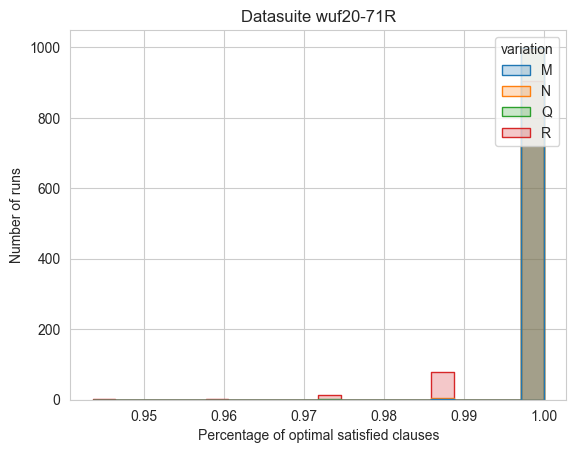

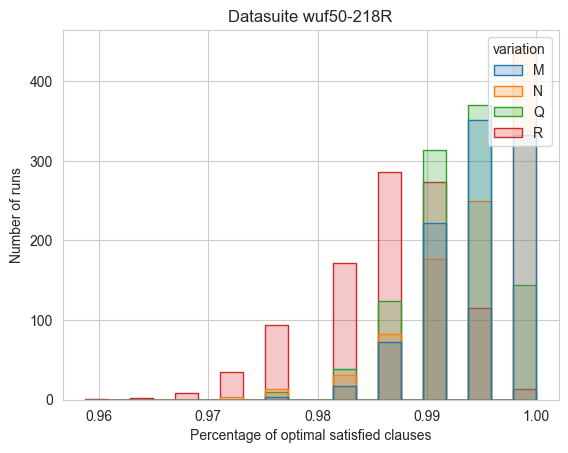

In [110]:
for experiment in black_box_experiemnts:
    df = pd.DataFrame.from_records(black_box_experiemnts[experiment])
    df['Satisfied ratio'] = df['satisfied_ratio']

    datas = []
    for i in range(len(df)):
        df_suite = df.iloc[[i]]
        variation = df_suite['variation'].values[0]
        for x, val in enumerate(df['Satisfied ratio'][i]):
            datas.append([x, val, variation])
    df = pd.DataFrame(datas, columns=['x', 'value', 'variation'])

    ax = sns.histplot(data=df, bins=20, x='value', hue='variation', element="step")
    #ax.set_xlim([0.8, 1])
    ax.set_title(f'Datasuite {experiment}')
    ax.set_xlabel('Percentage of optimal satisfied clauses')
    ax.set_ylabel(f'Number of runs')
    plt.show()